# Read the Data

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 31 14:38:34 2018

@author: thelightofking
"""
# Importing Packages
import pandas as pd
import re # Regular Expression is used to do certain selecting
import matplotlib.pyplot as plt
import seaborn as sns



time=list(range(1984,2019))
regex=r'\|(.*?)\|' #Set up the regex expression
pat=re.compile(regex,re.S)#Compile the regex expression to make the selection faster

big_date=[] #Empty list to hold the date
big_numbers=[] #Empty list to hold the Conus data
for years in time:
    url='ftp://ftp.cpc.ncep.noaa.gov/htdocs/degree_days/weighted/daily_data/'+str(years)+'/Population.Heating.txt'
    data=pd.read_table(url)
    date=data.iloc[2].values[0]
    numbers=data.iloc[12].values[0]
    date=pat.findall(date)
    numbers=pat.findall(numbers)
    big_date.append(date)
    big_numbers.append(numbers)

# Aggregate into One DataFrame

In [2]:
final_numbers=[]
final_date=[]
for every_date in range(len(big_numbers)):
    for every_number in range(len(big_numbers[every_date])):
        final_numbers.append(big_numbers[every_date][every_number])
        final_date.append(big_date[every_date][every_number])
table=pd.DataFrame(final_numbers,columns=['CONUS'],index=final_date)#index=pd.to_datetime(final_date))
table=table.astype(float)

# Plot the Mean vs Month

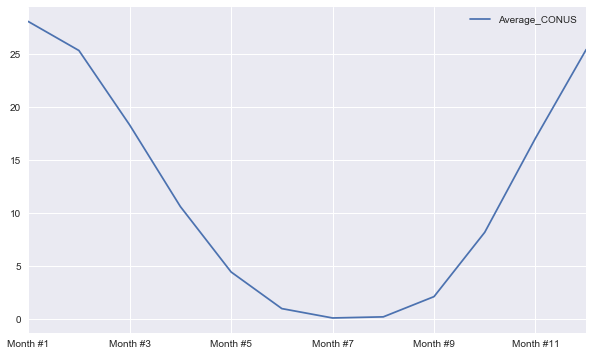

In [3]:
Month=pd.DataFrame(columns=['Average_CONUS'])
for i in range(1,13):
    if i<10:
        string='0'+str(i)# Seting up the regular expression for month between 1 and 9
    else:
        string=str(i) # Setting up the regular expression for month between 10 and 12
    number=table.filter(regex='\d\d\d\d'+str(string)+'\d\d',axis=0).mean().values[0]
    Month.loc['Month #'+str(i)]=number
Month.plot(figsize=(10,6))
plt.show()

# Estimation with PYMC3

In [4]:
import pymc3 as pm
# Data Preparation
jan=table.filter(regex='\d\d\d\d01\d\d',axis=0)# Select Data Exclusively for Janunary of each year
dec=table.filter(regex='\d\d\d\d12\d\d',axis=0)# Select Data Exclusively for December of each year
# As the number of jan and dec data are different, I find the mean of Jan/Dec for each year first then take the difference
diff_list=[]
for years in time:
    diff=table.filter(regex=''+str(years)+'01\d\d',axis=0).mean().values[0]-table.filter(regex=''+str(years)+'12\d\d',axis=0).mean().values[0]
    diff_list.append(diff)
diff_list=pd.DataFrame(diff_list)
diff_list=diff_list.dropna(how='any')
# End of Data Preparation

# Setting up the training parameters, the prior estimate parameters are set based upon the question description
basic_model = pm.Model()
with basic_model:
    mu_jan=pm.Normal('mu_jan',mu=50,sd=16) # The naïve prior estimate of the mean of Jan
    mu_dec=pm.Normal('mu_dec',mu=50,sd=16) # The naïve prior estimate of the mean of Dec
    sigma_jan=pm.Normal('sigma_jan',mu=10,sd=3) # The naïve prior estimate of the std of Jan
    sigma_dec=pm.Normal('sigma_dec',mu=10,sd=3) # The naïve prior estimate of the std of Dec
    
    diff_=pm.Normal('diff_',mu=0,sd=16) # The naïve prior estimate of the mean of differnce
    sigma_diff=pm.Normal("sigma_diff",mu=3,sd=1) # The naïve prior estimate of the variance of differnce
    
    jan=pm.Normal('jan',mu=mu_jan,sd=sigma_jan,observed=jan.values)# The posterior estimate of the mean of jan
    dec=pm.Normal('dec',mu=mu_dec,sd=sigma_dec,observed=dec.values)# The posterior estimate of the mean of dec
    diff_new=pm.Normal('diff',mu=diff_,sd=sigma_diff,observed=diff_list.values)# The posterior estimate of the mean of difference

with basic_model:
    trace = pm.sample(2000)# MCMC Sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_diff, diff_, sigma_dec, sigma_jan, mu_dec, mu_jan]
100%|██████████| 2500/2500 [00:06<00:00, 400.38it/s]


# Plot with Seaborn

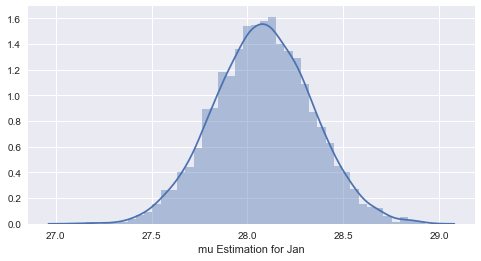

In [5]:
"""
Plot to demonstrate the result
"""
sns.set(rc={"figure.figsize": (8, 4)})
ax = sns.distplot(trace.get_values('mu_jan'),hist=True,axlabel="mu Estimation for Jan")
plt.show()

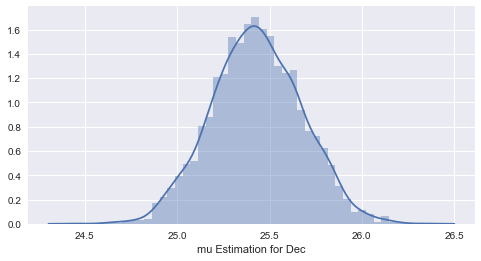

In [6]:
sns.set(rc={"figure.figsize": (8, 4)})
ax1 = sns.distplot(trace.get_values('mu_dec'),hist=True,axlabel="mu Estimation for Dec")
plt.show()

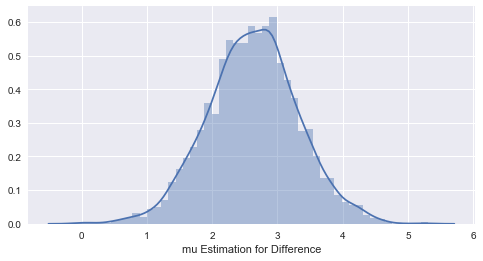

In [7]:
sns.set(rc={"figure.figsize": (8, 4)})
ax = sns.distplot(trace.get_values('diff_'),hist=True,axlabel="mu Estimation for Difference")
plt.show()